# Configuracion

### Carga de librerias

In [1]:
from Metadatos import generaPathProyecto, RMSLE
from CargaDatos import retornaSets
from Preparacion import preparaDf, separacionEntrenaObjetivo
from Modelo import definirModelo
from CargaDatos import generaPath
from Salida import generarEnvio

In [2]:
import ggplot as gg

In [3]:
%matplotlib inline

In [4]:
import numpy as np

### Definicion de funciones

In [11]:
def logTransf(df):
    return np.log(df + 1)

def antilogTransf(df):
    return np.exp(df) - 1

In [37]:
def validarModelo():
    dScores = {'best' : -modelo.best_score_,
               'train' : RMSLE(y_train, antilogTransf(modelo.predict(X_train))),
               'test' : RMSLE(y_test, antilogTransf(modelo.predict(X_test)))}
    print str('La mejor puntuacion de la crossvalidacion fue: {}\n' +
              'La puntuacion del entrenamiento fue: {}\n' +
              'La puntuacion de la prueba fue: {}').format(dScores['best'], dScores['train'], dScores['test'])

# Ejecucion de rutina

### Entrenamiento

In [38]:
path_proyecto = generaPathProyecto()
sets_df = retornaSets(path_proyecto = path_proyecto)

In [39]:
prepDf = preparaDf()
df = prepDf.preparar(sets_df)
X_train, X_test, y_train, y_test = separacionEntrenaObjetivo(df, semilla = 1962, prop_prueba= 0.3)

In [40]:
modelo = definirModelo()
modelo.fit(X = X_train.values, y = logTransf(y_train).values.reshape(y_train.shape[0],))

GridSearchCV(cv=None,
       estimator=Pipeline(steps=[('imputador', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('escalador', StandardScaler(copy=True, with_mean=True, with_std=True)), ('decisor', RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=None, max_fea...ples_split=2, n_estimators=10, n_jobs=1, oob_score=False,
           random_state=1962, verbose=0))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'decisor__n_estimators': [25, 30, 35], 'decisor__min_samples_split': [1, 2, 4, 8, 16], 'decisor__min_samples_leaf': [1, 2, 4, 8, 16]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring=make_scorer(RMSLE, greater_is_better=False), verbose=0)

### Presentacion de resultados

In [41]:
modelo.best_params_

{'decisor__min_samples_leaf': 1,
 'decisor__min_samples_split': 4,
 'decisor__n_estimators': 35}

In [42]:
validarModelo()

La mejor puntuacion de la crossvalidacion fue: 0.0952335201714
La puntuacion del entrenamiento fue: 0.112892210484
La puntuacion de la prueba fue: 0.246468296612


### Eliminacion de valores atipicos

In [9]:
import pandas as pd

In [10]:
vectErrores = (y_train - pd.DataFrame(data= modelo.predict(X_train), index= X_train.index, columns= ['cost']))**2

In [11]:
cuartiles = vectErrores.quantile(q= [0.25, 0.75])

In [12]:
ric = cuartiles.iloc[1, 0] - cuartiles.iloc[0, 0]

In [13]:
cuartiles.iloc[0, 0] - 1.5*ric, cuartiles.iloc[1, 0] + 1.5*ric

(-1.1688718202207828, 1.9540742169150593)

In [14]:
indice = vectErrores[vectErrores.cost < cuartiles.iloc[1, 0] + 1.5*ric].index

In [15]:
X_train = X_train.ix[indice,]

In [16]:
y_train = y_train.ix[indice,]

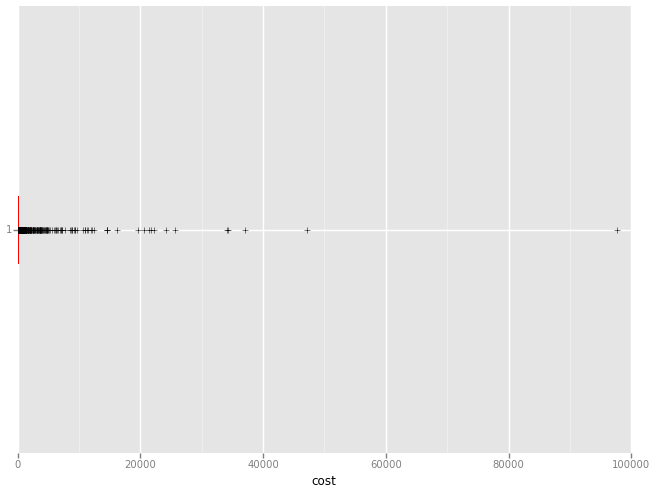

<ggplot: (8756043915701)>

In [36]:
gg.ggplot(gg.aes(x= 'cost'), data= vectErrores) + gg.geom_boxplot()

### Experimentacion

In [33]:
a = modelo.best_estimator_.steps[2][1]

In [43]:
impDf = pd.DataFrame(data= zip(X_train.columns, a.feature_importances_), columns= ['nombre', 'importancia'])

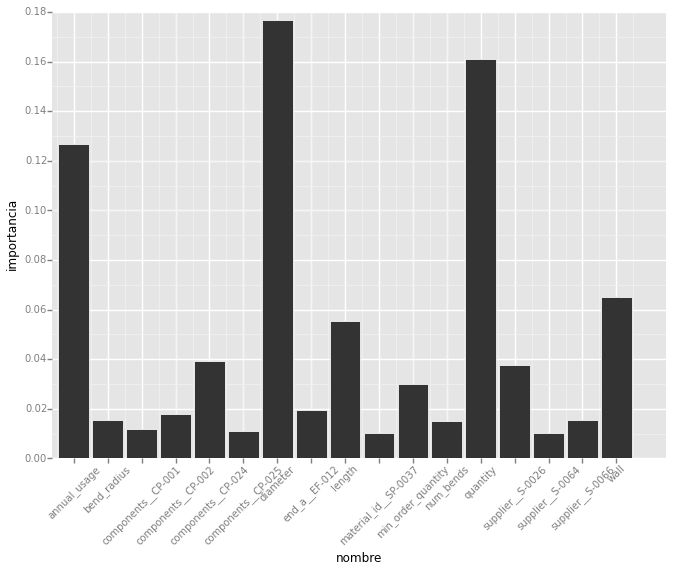

<ggplot: (8761972715477)>

In [62]:
gg.ggplot(gg.aes(x= 'nombre', y= 'importancia'), data= impDf[impDf.importancia >= 0.01]) +\
gg.geom_bar(stat= 'identity') + gg.theme(axis_text_x= gg.element_text(angle= 45))

### Envio

In [23]:
X_envio = prepDf.preparar(sets_df, train_o_envio= 'test')
generarEnvio(modelo, X_envio)

In [24]:
import pandas as pd

In [25]:
path_envio = '~/Proyectos/caterpillar_tube_pricing/Bases/Locales/y_envio_20150727_142316.txt'

In [27]:
y_envio = pd.read_csv(path_envio)

In [28]:
y_envio.cost = antilogTransf(y_envio.cost)

In [33]:
path_envio2 = '/home/numerodelcaos_gmail_com/Proyectos/caterpillar_tube_pricing/Bases/Locales/y_envio_20150727_142316_2.txt'

In [35]:
y_envio.to_csv(path_envio2, index = False)

In [25]:
validarModelo?